
# Serialización del Modelo (Pipeline + Manifest)

**Objetivo:**

Entrenar un modelo de clasificación, evaluarlo, **serializarlo en un único artefacto** (`joblib`) usando un **`Pipeline`** (incluye `StandardScaler`), y registrar un **manifest/model card** con métricas, parámetros y versiones para trazabilidad. Finalmente, **deserializar** el artefacto y realizar predicciones de ejemplo de forma segura (validando esquema de entrada).



## 1. Setup y configuración reproducible
- Fijamos semillas.
- Creamos la carpeta `artifacts/` para almacenar el modelo y el `model_card.json`.


In [1]:
import numpy as np, pandas as pd, json, os, joblib, time, platform, sklearn
from pathlib import Path
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score,
                             recall_score, f1_score, roc_auc_score, RocCurveDisplay)
import matplotlib.pyplot as plt

In [2]:
# Semillas
RANDOM_STATE = 41
np.random.seed(RANDOM_STATE)

# Paths
ARTIFACTS_DIR = Path("artifacts")
ARTIFACTS_DIR.mkdir(exist_ok=True)

print("scikit-learn version:", sklearn.__version__)
print("Python version:", platform.python_version())


scikit-learn version: 1.6.1
Python version: 3.12.11


In [3]:
pd.__version__

'2.2.2'


## 2. Datos
El notebook intentará cargar `SocialNetworkAds.csv` con las columnas **`Age`**, **`EstimatedSalary`** y **`Purchased`**.  
Si el archivo **no existe**, se generará un dataset sintético con la misma estructura para que el notebook sea 100% ejecutable.


In [4]:
df = pd.read_csv("SocialNetworkAds.csv")

In [5]:
df.head(3)

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0



## 3. Split de entrenamiento y prueba (estratificado)
Usamos `stratify=y` para mantener la proporción de clases entre los conjuntos.


In [6]:
# seleccion de features para el modelo
X = df[['Age', 'EstimatedSalary']].copy()
y = df['Purchased'].astype(int)

# division de datos
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

X_train.shape, X_test.shape, y_train.mean(), y_test.mean()


((300, 2), (100, 2), np.float64(0.3566666666666667), np.float64(0.36))


## 4. `Pipeline` + Búsqueda de hiperparámetros
Creamos un `Pipeline` (`StandardScaler` + `KNeighborsClassifier`) y hacemos `GridSearchCV` con métrica F1.


In [7]:
pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("clf", KNeighborsClassifier())
])

param_grid = {
    "clf__n_neighbors": [3,5,7,9,11],
    "clf__weights": ["uniform", "distance"],
    "clf__p": [1,2]  # Manhattan / Euclidiana
}

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="f1",  # Cambia a 'balanced_accuracy' si hay desbalance fuerte
    cv=5,
    n_jobs=-1,
    verbose=0
)


In [8]:
# Entrenamiento
grid.fit(X_train, y_train)



GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'clf__n_neighbors': [3, 5, 7, 9, 11], 'clf__p': [1, 2],
                         'clf__weights': ['uniform', 'distance']},
             scoring='f1')

In [9]:
# Resultado
best_model = grid.best_estimator_
print("Mejores params:", grid.best_params_)
print("Mejor F1 CV:   ", round(grid.best_score_, 4))

Mejores params: {'clf__n_neighbors': 9, 'clf__p': 1, 'clf__weights': 'uniform'}
Mejor F1 CV:    0.8874



## 5. Evaluación en test
Calculamos **accuracy, precision, recall, f1** y, si el modelo soporta probabilidades, **ROC AUC**.  
Mostramos también la **matriz de confusión** y (opcionalmente) la curva ROC.


In [11]:
y_pred = best_model.predict(X_test)
predict_proba = getattr(best_model, "predict_proba", None)
proba_1 = predict_proba(X_test)[:,1] if predict_proba is not None else None

In [12]:
metrics = {
    "accuracy": float(accuracy_score(y_test, y_pred)),
    "precision": float(precision_score(y_test, y_pred, zero_division=0)),
    "recall": float(recall_score(y_test, y_pred, zero_division=0)),
    "f1": float(f1_score(y_test, y_pred, zero_division=0)),
}

if proba_1 is not None:
    metrics["roc_auc"] = float(roc_auc_score(y_test, proba_1))

cm = confusion_matrix(y_test, y_pred)
print("Métricas en test:", json.dumps(metrics, indent=2))
print("Matriz de confusión:\n", cm)


Métricas en test: {
  "accuracy": 0.92,
  "precision": 0.868421052631579,
  "recall": 0.9166666666666666,
  "f1": 0.8918918918918919,
  "roc_auc": 0.9342447916666667
}
Matriz de confusión:
 [[59  5]
 [ 3 33]]


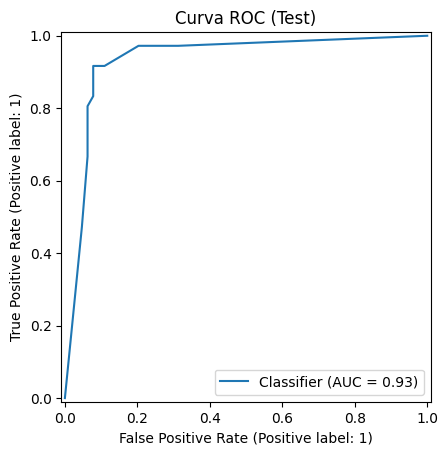

In [13]:
# Curva ROC
RocCurveDisplay.from_predictions(y_test, proba_1);
plt.title("Curva ROC (Test)");
plt.show()



## 6. Serialización del modelo (un solo artefacto)
Guardamos el `Pipeline` completo con `joblib`.


In [14]:
model_path = ARTIFACTS_DIR / "knn_pipeline.pkl"
joblib.dump(best_model, model_path)
print("Artefacto guardado en:", model_path.resolve())


Artefacto guardado en: /content/artifacts/knn_pipeline.pkl



## 7. Manifest / Model Card

Un **manifiesto** (o *model card*) es un archivo de acompañamiento que documenta la información clave sobre un modelo de Machine Learning.  
Su propósito es **garantizar trazabilidad, transparencia y reutilización** del modelo en el tiempo.

En el contexto de despliegue de modelos, el manifiesto suele incluir:

- **Identificación del modelo**:  Nombre, versión, autor, fecha de creación.

- **Entorno y dependencias**:   Versiones de librerías y frameworks (por ejemplo, scikit-learn 1.5, Python 3.11).

- **Datos de entrenamiento**: Conjunto de datos utilizado, variables (*features*), variable objetivo (*target*).

- **Configuración y parámetros**: Hiperparámetros seleccionados, random seed, métricas de validación cruzada.

- **Resultados de evaluación**: Métricas de desempeño en el conjunto de prueba (accuracy, precision, recall, f1, ROC AUC).

- **Consideraciones de uso**: Contexto en que el modelo es válido, limitaciones conocidas y posibles sesgos.

### Beneficios
- Permite **reproducir** los resultados del modelo.  
- Facilita la **auditoría y monitoreo** en producción.  
- Ayuda a **detectar degradación** de performance con el tiempo.  
- Mejora la **comunicación entre equipos** (científicos de datos, ingenieros, negocio).

En este módulo, el manifiesto se implementa como un archivo `model_card.json` que acompaña al archivo serializado (`.pkl`). De esta forma, cada artefacto desplegado cuenta con su propia "ficha técnica".

Guardamos un JSON con:
- Nombre del experimento/modelo
- Timestamps
- Versiones de librerías
- Features / target
- Hiperparámetros óptimos y **métrica de CV**
- Métricas en test


In [ ]:

manifest = {
    "name": "KNN-Pipeline-SocialNetworkAds",
    "created_at": time.strftime("%Y-%m-%d %H:%M:%S"),
    "framework": "scikit-learn",
    "sklearn_version": sklearn.__version__,
    "python_version": platform.python_version(),
    "random_state": RANDOM_STATE,
    "features": list(X.columns),
    "target": "Purchased",
    "best_params": grid.best_params_,
    "cv_metric": "f1",
    "cv_best_score": float(grid.best_score_),
    "test_metrics": metrics,
}

manifest_path = ARTIFACTS_DIR / "model_card.json"
with open(manifest_path, "w", encoding="utf-8") as f:
    json.dump(manifest, f, indent=2, ensure_ascii=False)

print("Manifest guardado en:", manifest_path.resolve())
manifest


Manifest guardado en: /content/artifacts/model_card.json


{'name': 'KNN-Pipeline-SocialNetworkAds',
 'created_at': '2025-09-23 01:19:21',
 'framework': 'scikit-learn',
 'sklearn_version': '1.6.1',
 'python_version': '3.12.11',
 'random_state': 41,
 'features': ['Age', 'EstimatedSalary'],
 'target': 'Purchased',
 'best_params': {'clf__n_neighbors': 9,
  'clf__p': 1,
  'clf__weights': 'uniform'},
 'cv_metric': 'f1',
 'cv_best_score': 0.887360970677452,
 'test_metrics': {'accuracy': 0.92,
  'precision': 0.868421052631579,
  'recall': 0.9166666666666666,
  'f1': 0.8918918918918919,
  'roc_auc': 0.9342447916666667}}


## 8. Próximos pasos
- Exponer el artefacto en una **API Flask** (carga del `.pkl`, validación del payload y predicción).
- Añadir **tests unitarios** mínimos: cargar artefacto y validar que la métrica en test se mantenga por encima de un umbral.
- Integrar telemetría/monitoring de **drift** de datos y **degradación** de performance.
